In [1]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

# Determine number of "events" that happen per year, and then establish your return period of interest

In [27]:
return_period = 50 # in years
#events_per_year = 151-40
events_per_year = 151/3

#return_period = 100
#events_per_year = 1

return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

99.96026490066225


In [28]:
working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'
#save_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calculations/npy_files/'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [29]:
working_dir = '/Users/baird/google_drive/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/'
#threshold=0.0
threshold=0.1
#threshold=0.5
#threshold=1.0
#threshold=5.0
#threshold=10.0

In [30]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

# Open preindustrial control data

In [31]:
year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]

# create season strings
years_pic = numpy.arange(year_start_pic, year_end_pic+1, 1).astype(numpy.int)
half_years_pic = numpy.arange(year_start_pic+0.75, year_end_pic, 1)
#season_strings_pic = numpy.empty(years.size-1, dtype=numpy.str)

season_strings_pic = [str(years_pic[i])+'-'+str(years_pic[i+1]) for i in range(years_pic.size-1)]
member_strings_pic = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_pic=year_end_pic-year_start_pic

Steps:

1.  Import all data for PIC (at each grid point, you should have 1798 years of storm magnitude lists)
2.  At each grid point, pool all of these data together
3.  At each grid point, calculate the 99th percentile and COUNT THE NUMBER OF STORMS LARGER THAN THIS
4.  Store this number and also calculate a "events per season" number by dividing by number of years

Then when doing end-of-century stuff:

1.  Import all data for hist and RCP 8.5 for a 30-year chunk (at each grid point, you'll have 40$\times$30 years of data)
2.  Then for each grid point, calculate the number of times the 99th percentile in PIC was exceeded in hist/RCP
3.  Sum the number of exceedences, divide by (normalize by) the number of years (in this case, 30$\times$40)
4.  Take this value and divide it by the PIC value.

In [32]:
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain_extras/'
# for each grid point:
# cycle through all times, get extreme seasonal sum in each time period, store in array with length(season_strings_pic)
# once this is done, calculate the return periods of each of these
return_period_values_pic = numpy.zeros(( PRECT_nlat*PRECT_nlon, 2))

for latlon_idx in range(len(latlon_indices)):
    if latlon_idx%10==0:
        print(latlon_idx)
    filename = 'member_005_latidx_'+'{:02d}'.format(latlon_indices[latlon_idx][0])+'_lonidx_'+'{:02d}'.format(latlon_indices[latlon_idx][1])+'_years_'+'{:04d}'.format(year_start_pic)+'-'+'{:04d}'.format(year_end_pic)+'_threshold_'+str(threshold)+'mmday_'+region+'_extras.npy'
    dict_pic = numpy.load(working_dir + filename).item()
    #print(dict_pic['402-403'].keys())
    events_list = [dict_pic[i]['running_3d_sum'] for i in dict_pic.keys()]
    events_list = [i for sublist in events_list for i in sublist]
    return_period_values_pic[latlon_idx,0] = numpy.nanpercentile(events_list, return_val_perc)#, interpolation='nearest')
    return_period_values_pic[latlon_idx,1] = numpy.nansum(events_list>return_period_values_pic[latlon_idx,0])

0


/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640


In [33]:
return_period_values_pic_df = pandas.DataFrame(return_period_values_pic)
return_period_values_pic_df.to_csv('csv_files/return_period_values_pic_df.csv')

In [34]:
return_period_values_pic_df = pandas.read_csv('csv_files/return_period_values_pic_df.csv')
return_period_values_pic = return_period_values_pic_df.values[:,1:]

# Open historical and RCP8.5 data

In [35]:
year_start = 2070
year_end = 2100

year_start_list = [1920,1950,1980,2010,2040,2070]
year_end_list = [1950,1980,2010,2040,2070,2100]

# create season strings
years = numpy.arange(year_start, year_end+1, 1).astype(numpy.int)
half_years_hist_rcp = numpy.arange(year_start+0.75, year_end, 1)

season_strings_hist_rcp = [str(years[i])+'-'+str(years[i+1]) for i in range(years.size-1)]
member_strings_hist_rcp = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_hist_rcp=year_end-year_start

In [36]:
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

# Also save as npy file

In [38]:
all_events_hist_rcp = numpy.load('csv_files/all_events_hist_rcp_npy.npy')

# Load data as csv file

all_events_hist_rcp_df = pandas.read_csv('csv_files/all_events_hist_rcp_df.csv')
all_events_hist_rcp = all_events_hist_rcp_df.values[:,1:]

In [39]:
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'
# for each grid point:
# cycle through all times, get extreme seasonal sum in each time period, store in array with length(season_strings_pic)
# once this is done, calculate the return periods of each of these
return_period_values_hist_rcp = numpy.zeros(( PRECT_nlat*PRECT_nlon, 3 ))

for latlon_idx in range(len(latlon_indices)):
    all_events = all_events_hist_rcp[latlon_idx,:]
    return_period_values_hist_rcp[latlon_idx,0] = numpy.nanpercentile(all_events, return_val_perc)
    return_period_values_hist_rcp[latlon_idx,1] = numpy.nansum(all_events>return_period_values_hist_rcp[latlon_idx,0])
    return_period_values_hist_rcp[latlon_idx,2] = numpy.nansum(all_events>return_period_values_pic[latlon_idx,0])
return_period_values_hist_rcp_df = pandas.DataFrame(return_period_values_hist_rcp, columns=['Perc value hist eoc','Num hist eoc exceedances','Num PIC exceedances'])
csv_filename = 'return_period_values_hist_rcp_dataframe_'+str(year_start)+'-'+str(year_end)+'.csv'
return_period_values_hist_rcp_df.to_csv('csv_files/'+csv_filename)
print(csv_filename, 'written!')

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


return_period_values_hist_rcp_dataframe_2070-2100.csv written!


In [40]:
print(return_val_perc)

99.96026490066225


In [41]:
return_period_values_hist_rcp_df = pandas.read_csv('csv_files/return_period_values_hist_rcp_dataframe_'+str(year_start)+'-'+str(year_end)+'.csv')
return_period_values_hist_rcp = return_period_values_hist_rcp_df.values[:,1:]

In [42]:
pic_counts = return_period_values_pic[:,1]
hist_rcp_counts = return_period_values_hist_rcp[:,2]

# Plot return values for PIC

In [43]:
return_values_pic_2d = return_period_values_pic[:,0].reshape(PRECT_nlat, PRECT_nlon)

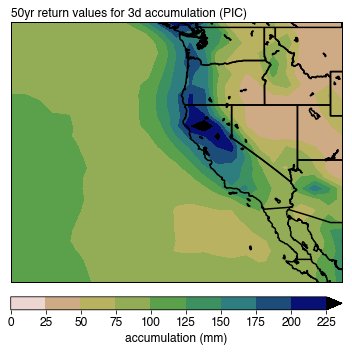

In [51]:
fontsize=12
contour_levels = numpy.arange(0,226,25)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, return_values_pic_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('accumulation (mm)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)

ax.text(s='50yr return values for 3d accumulation (PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('50yr_return_values_3d_accumulation_PIC.pdf', transparent=True, bbox_inches='tight')

# Plot hist and RCP map

In [49]:
return_values_hist_rcp_2d = return_period_values_hist_rcp[:,0].reshape(PRECT_nlat, PRECT_nlon)

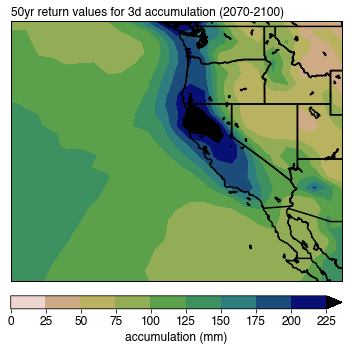

In [57]:
fontsize=12
contour_levels = numpy.arange(0,226,25)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, return_values_hist_rcp_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('accumulation (mm)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)

ax.text(s='50yr return values for 3d accumulation (2070-2100)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('50yr_return_values_3d_accumulation_2070-2100.pdf', transparent=True, bbox_inches='tight')

# Plot relative change in PIC 100yr return interval exceedances

In [53]:
count_ratio = (hist_rcp_counts/(30*40))/(pic_counts/1798)
count_ratio_2d = count_ratio.reshape((PRECT_nlat, PRECT_nlon))

In [54]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [55]:
# make color map
minval=0.0 # 
maxval=0.85 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

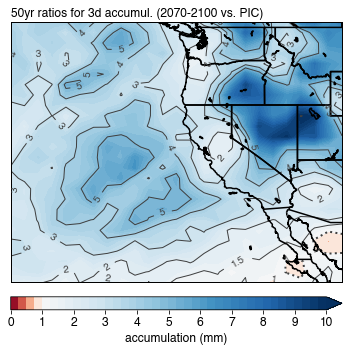

In [56]:
fontsize=12
contour_levels = numpy.arange(0,10.01,0.25)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

#pr_map = map.contourf(xi, yi, count_ratio_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

pr_map = map.contourf(xi, yi, count_ratio_2d, \
                      #cmap='inferno', \
                      cmap='RdBu', \
                      norm=MidpointNormalize(midpoint=1.0), \
                      levels=contour_levels, \
                      zorder=2, \
                      extend='max', \
                      latlon=True)
contour_plot = pr_contour = map.contour(xi, yi, count_ratio_2d, \
                         levels=[0.5,1.,1.5,2,3,4,5.,10.,15.,20.,25.,30.], \
                         colors='0.25', \
                         linewidths=[1]*1+[2]+[1]*10, \
                         linestyles=['--']*1+[':']+['-']*10, \
                         )

new_levels = []
for i in contour_plot.levels:
    if i in [0.5,1.5]:
        new_levels.append('{:.1f}'.format(i))
    else:
        new_levels.append('{:.0f}'.format(i))
contour_plot.levels = new_levels
mp.clabel(contour_plot, fontsize=fontsize-2, colors=['0.25']*7+['0.75']*5)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('accumulation (mm)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)
cbar.set_ticks([0,1,2,3,4,5,6,7,8,9,10])

ax.text(s='50yr ratios for 3d accumul. (2070-2100 vs. PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('50yr_return_values_3d_accumulation_RATIOS.pdf', transparent=True, bbox_inches='tight')